In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW, Yogi  # You need TensorFlow Addons for AdamW and Yogi
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\werka\miniconda3\envs\py310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

In [2]:
class DataPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.encoder = OneHotEncoder()
    
    def load_data(self, file_path):
        dataset = pd.read_csv(file_path)
        X = dataset.iloc[:,:20]
        y = dataset.iloc[:,20:21]
        return X, y

    def split_data(self, X, y, test_size=0.1, validation_size=0.1):
        # Split data into training and temporary data
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size + validation_size)
        
        # Determine remaining size after test and validation set
        remaining_size = 1 - (test_size + validation_size)
        
        # Calculate ratio between validation and remaining data
        validation_ratio = validation_size / (validation_size + remaining_size)
        
        # Split temporary data into testing and validation data
        X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=validation_ratio)
        
        return X_train, X_test, X_val, y_train, y_test, y_val

    def normalize_features(self, X):
        return self.scaler.fit_transform(X)

    def encode_targets(self, y):
        return self.encoder.fit_transform(y).toarray()


In [3]:
class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_ann(self, input_dim, optimizer='adam'):
        # Initialize and compile the model within the build_ann method
        self.model = Sequential()
        self.model.add(Dense(16, input_dim=input_dim, activation='relu'))
        self.model.add(Dense(12, activation='relu'))
        self.model.add(Dense(4, activation='softmax'))
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        # self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        return self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

    def evaluate(self, X_test, y_test):
        y_pred_prob = self.model.predict(X_test)
        y_pred = np.round(y_pred_prob).astype(int).flatten()
        if isinstance(y_test, pd.Series):
           y_test = y_test.values
        y_true = y_test.flatten()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        return accuracy, precision, recall, f1

In [4]:
# Main process
data_preprocessor = DataPreprocessor()
Xc, yc = data_preprocessor.load_data('mobile-train (1).csv')
X = data_preprocessor.normalize_features(Xc)
y = data_preprocessor.encode_targets(yc)
X_train, X_test, X_val, y_train, y_test, y_val = data_preprocessor.split_data(X, y)

In [5]:
# # Define reduction percentages
# reduction_percentage = 0.7

# # Reduce the size of the datasets
# X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=reduction_percentage, random_state=42)
# X_val, _, y_val, _ = train_test_split(X_val, y_val, test_size=reduction_percentage, random_state=42)
# X_test, _, y_test, _ = train_test_split(X_test, y_test, test_size=reduction_percentage, random_state=42)

In [6]:
X_train.shape , X_val.shape, X_test.shape,  y_train.shape

((1600, 20), (45, 20), (355, 20), (1600, 4))

In [7]:
# List of optimizers to test for NN
optimizers = {
    'SGD': SGD(),
    'SGD_momentum': SGD(momentum=0.9),
    'Nesterov': SGD(momentum=0.9, nesterov=True),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adam': Adam(),
    'AMSGrad': Adam(amsgrad=True),
    'AdamW': AdamW(weight_decay=1e-4),
    'Yogi': Yogi(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Adamax': tf.keras.optimizers.Adamax()
}

results = {}

# neural_network_model = NeuralNetworkModel()

for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    neural_network_model = NeuralNetworkModel()
    neural_network_model.build_ann(X_train.shape[1], optimizer=optimizer)
    start_time = time.time()
    history = neural_network_model.train(X_train, y_train, X_val, y_val, epochs=50, batch_size=32)
    end_time = time.time()
    test_accuracy, precision, recall, f1 = neural_network_model.evaluate(X_test, y_test)
    training_time = end_time - start_time
    convergence_speed = len(history.history['loss'])
    results[name] = {
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'convergence_speed': convergence_speed,
        'training_time': training_time,
        'history': history
    }

Training model with SGD optimizer...
Epoch 1/50
50/50 [==============================] - 2s 7ms/step - loss: 1.4338 - accuracy: 0.2775 - val_loss: 1.3741 - val_accuracy: 0.3333 - lr: 0.0100
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 1.3840 - accuracy: 0.3100 - val_loss: 1.3324 - val_accuracy: 0.4444 - lr: 0.0100
Epoch 3/50
50/50 [==============================] - 0s 4ms/step - loss: 1.3473 - accuracy: 0.3444 - val_loss: 1.2993 - val_accuracy: 0.3778 - lr: 0.0100
Epoch 4/50
50/50 [==============================] - 0s 4ms/step - loss: 1.3133 - accuracy: 0.3762 - val_loss: 1.2674 - val_accuracy: 0.3778 - lr: 0.0100
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 1.2789 - accuracy: 0.4006 - val_loss: 1.2350 - val_accuracy: 0.4000 - lr: 0.0100
Epoch 6/50
50/50 [==============================] - 0s 4ms/step - loss: 1.2403 - accuracy: 0.4381 - val_loss: 1.1989 - val_accuracy: 0.3778 - lr: 0.0100
Epoch 7/50
50/50 [===========================

In [8]:
# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Precision - {result['precision']:.4f}, "
          f"Recall - {result['recall']:.4f}, "
          f"F1-score - {result['f1_score']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")


Results:
SGD: Test Accuracy - 0.9620, Precision - 0.9619, Recall - 0.9620, F1-score - 0.9619, Convergence Speed - 50 epochs, Training Time - 17.03 seconds
SGD_momentum: Test Accuracy - 0.9634, Precision - 0.9634, Recall - 0.9634, F1-score - 0.9634, Convergence Speed - 26 epochs, Training Time - 9.75 seconds
Nesterov: Test Accuracy - 0.9690, Precision - 0.9690, Recall - 0.9690, F1-score - 0.9690, Convergence Speed - 20 epochs, Training Time - 7.55 seconds
RMSprop: Test Accuracy - 0.9592, Precision - 0.9592, Recall - 0.9592, F1-score - 0.9592, Convergence Speed - 50 epochs, Training Time - 19.99 seconds
Adagrad: Test Accuracy - 0.7514, Precision - 0.7024, Recall - 0.7514, F1-score - 0.6584, Convergence Speed - 50 epochs, Training Time - 18.22 seconds
Adadelta: Test Accuracy - 0.7394, Precision - 0.6050, Recall - 0.7394, F1-score - 0.6426, Convergence Speed - 50 epochs, Training Time - 19.25 seconds
Adam: Test Accuracy - 0.9620, Precision - 0.9620, Recall - 0.9620, F1-score - 0.9620, Con

In [9]:
# Data extraction for the summary
data_info = {
    'Data Name': ["Mobile Price"] * len(optimizers),
    'Data Size': [X_train.shape[0]] * len(optimizers),
    'Number of Features': [X_train.shape[1]] * len(optimizers),
    'Target Feature Type': [y_train.dtype] * len(optimizers),
    'Neural Network Architecture': ["FNN"] * len(optimizers),
    'Optimization Method': list(optimizers.keys())
}

# Extract results for each optimization method
results_info = {
    'Optimization Method': [],
    'Test Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'Convergence Speed': [],
    'Training Time': [],
    'Training Loss': [],
    'Validation Loss': []
}

# Add the evaluation results for each optimizer
for optimizer, result in results.items():
    results_info['Optimization Method'].append(optimizer)
    results_info['Test Accuracy'].append(result['test_accuracy'])
    results_info['Precision'].append(result['precision'])
    results_info['Recall'].append(result['recall'])
    results_info['F1-score'].append(result['f1_score'])
    results_info['Convergence Speed'].append(result['convergence_speed'])
    results_info['Training Time'].append(result['training_time'])
    results_info['Training Loss'].append(result['history'].history['loss'][0])
    results_info['Validation Loss'].append(result['history'].history['val_loss'][0])

# Create DataFrames and merge them for final results
data_df = pd.DataFrame(data_info)
results_df = pd.DataFrame(results_info)
final_df = pd.merge(data_df, results_df, on='Optimization Method')

# Show the final merged data
final_df.head(12)

,Data Name,Data Size,Number of Features,Target Feature Type,Neural Network Architecture,Optimization Method,Test Accuracy,Precision,Recall,F1-score,Convergence Speed,Training Time,Training Loss,Validation Loss
0,Mobile Price,1600,20,float64,FNN,SGD,0.961972,0.961905,0.961972,0.961936,50,17.028944,1.433764,1.374079
1,Mobile Price,1600,20,float64,FNN,SGD_momentum,0.963380,0.963380,0.963380,0.963380,26,9.751960,1.359100,1.263355
2,Mobile Price,1600,20,float64,FNN,Nesterov,0.969014,0.969014,0.969014,0.969014,20,7.551522,1.376899,1.298623
3,Mobile Price,1600,20,float64,FNN,RMSprop,0.959155,0.959155,0.959155,0.959155,50,19.994000,1.484845,1.448275
4,Mobile Price,1600,20,float64,FNN,Adagrad,0.751408,0.702351,0.751408,0.658424,50,18.215614,1.558246,1.511200
5,Mobile Price,1600,20,float64,FNN,Adadelta,0.739437,0.605039,0.739437,0.642578,50,19.246867,1.467821,1.569361
6,Mobile Price,1600,20,float64,FNN,Adam,0.961972,0.961972,0.961972,0.961972,50,19.491093,1.622455,1.367365
7,Mobile Price,1600,20,float64,FNN,AMSGrad,0.961972,0.961972,0.961972,0.961972,50,20.837393,1.516596,1.425749
8,Mobile Price,1600,20,float64,FNN,AdamW,0.969014,0.969014,0.969014,0.969014,50,18.238550,1.499531,1.424369
9,Mobile Price,1600,20,float64,FNN,Yogi,0.967606,0.967606,0.967606,0.967606,31,14.876062,1.199947,0.945885


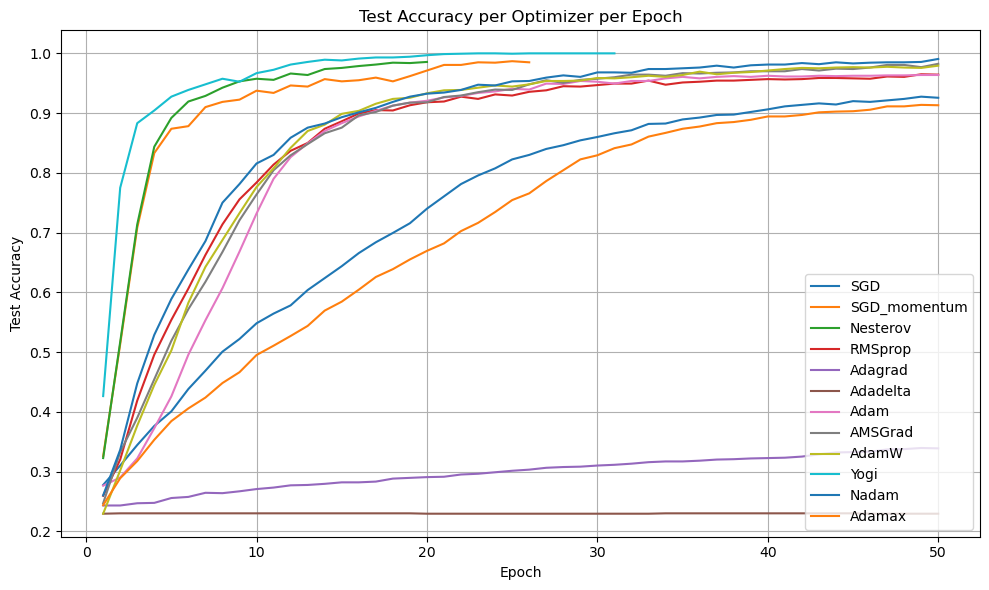

In [12]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Test Accuracy per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the validation accuracy history for this optimizer
    if 'accuracy' in result['history'].history:
        acc_history = result['history'].history['accuracy']
    else:
        # Sometimes the key might be 'val_acc', depending on TensorFlow version
        acc_history = result['history'].history.get('accuracy', [])

    # Plot the validation accuracy history
    plt.plot(range(1, len(acc_history) + 1), acc_history, label=optimizer_name)

plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy per Optimizer per Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


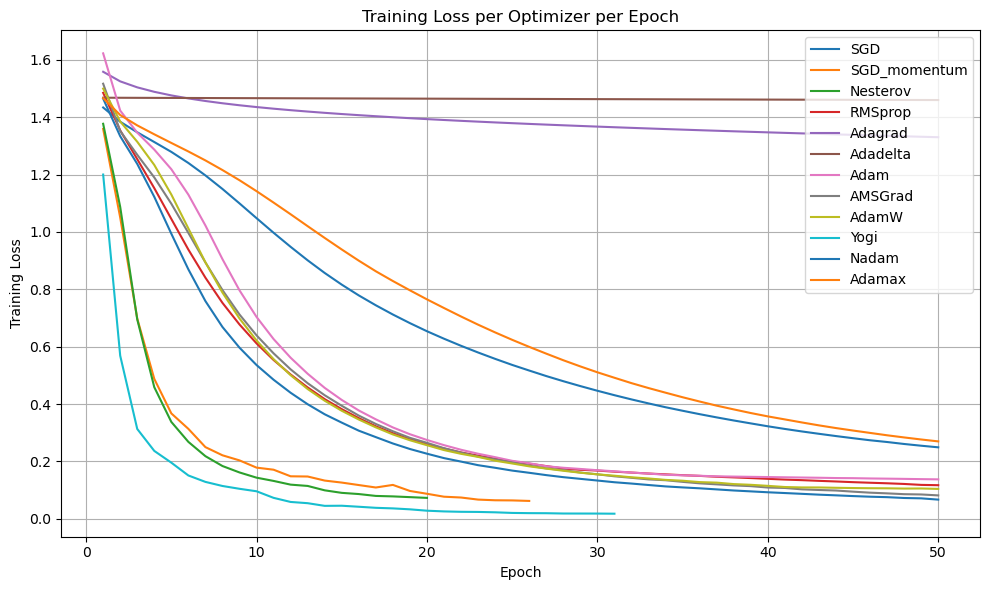

In [11]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Training Loss per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the training loss history for this optimizer
    if 'loss' in result['history'].history:
        loss_history = result['history'].history['loss']
    else:
        # In case the loss key isn't found (unexpected behavior), use a default empty list
        loss_history = []

    # Plot the training loss history
    plt.plot(range(1, len(loss_history) + 1), loss_history, label=optimizer_name)

# Set plot labels and titles
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Optimizer per Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
final_df.to_csv('Mobile Price_nn_r(3).csv', index=False)

###################################### Before Presentation ################################################

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
import time
import matplotlib.pyplot as plt


class DataPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.encoder = OneHotEncoder()
    
    def load_data(self, file_path):
        # Load dataset
        dataset = pd.read_csv(file_path)
        # Split dataset into features and target
        X = dataset.iloc[:,:20]
        y = dataset.iloc[:,20:21]
        return X, y

    def split_data(self, X, y, test_size=0.1):
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        return X_train, X_test, y_train, y_test

    def normalize_features(self, X):
        # Normalize the features
        return self.scaler.fit_transform(X)

    def encode_targets(self, y):
        # Encode target variable
        return self.encoder.fit_transform(y).toarray()




In [31]:
class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_ann(self, input_dim, optimizer='adam'):
        # Initialize and compile the model within the build_ann method
        model = Sequential()
        model.add(Dense(16, input_dim=input_dim, activation='relu'))
        model.add(Dense(12, activation='relu'))
        model.add(Dense(4, activation='softmax'))
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        self.model = model

    def train(self, X_train, y_train, epochs=100, batch_size=32, validation_data=None):
        # Train the model with the provided parameters
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)
        return history
    
    def evaluate(self, X_test, y_test):
        # Evaluate the model and return the results
        return self.model.evaluate(X_test, y_test)


In [2]:
# # Usage
# preprocessor = DataPreprocessor()
# X, y = preprocessor.load_data('mobile-train (1).csv')
# X = preprocessor.normalize_features(X)
# y = preprocessor.encode_targets(y)
# X_train, X_test, y_train, y_test = preprocessor.split_data(X, y, test_size=0.1)


# Main process
data_preprocessor = DataPreprocessor()
X, y = data_preprocessor.load_data('mobile-train (1).csv')
X = data_preprocessor.normalize_features(X)
y = data_preprocessor.encode_targets(y)
X_train, X_test, y_train, y_test = data_preprocessor.split_data(X, y)


In [6]:
X_test.shape

(200, 20)

Training model with SGD optimizer...
Epoch 1/2
57/57 [==============================] - 1s 11ms/step - loss: 1.4455 - accuracy: 0.2756 - val_loss: 1.4307 - val_accuracy: 0.2400
Epoch 2/2
7/7 [==============================] - 0s 5ms/step - loss: 1.3870 - accuracy: 0.2800
Training model with Adam optimizer...
Epoch 1/2
57/57 [==============================] - 1s 9ms/step - loss: 1.3738 - accuracy: 0.3172 - val_loss: 1.3574 - val_accuracy: 0.3400
Epoch 2/2
7/7 [==============================] - 0s 5ms/step - loss: 1.2712 - accuracy: 0.4250
Training model with RMSprop optimizer...
Epoch 1/2
57/57 [==============================] - 1s 13ms/step - loss: 1.3867 - accuracy: 0.3222 - val_loss: 1.3699 - val_accuracy: 0.3450
Epoch 2/2
7/7 [==============================] - 0s 4ms/step - loss: 1.2967 - accuracy: 0.4100
Training model with Adagrad optimizer...
Epoch 1/2
57/57 [==============================] - 1s 7ms/step - loss: 1.5299 - accuracy: 0.2333 - val_loss: 1.5268 - val_accuracy: 0.2700


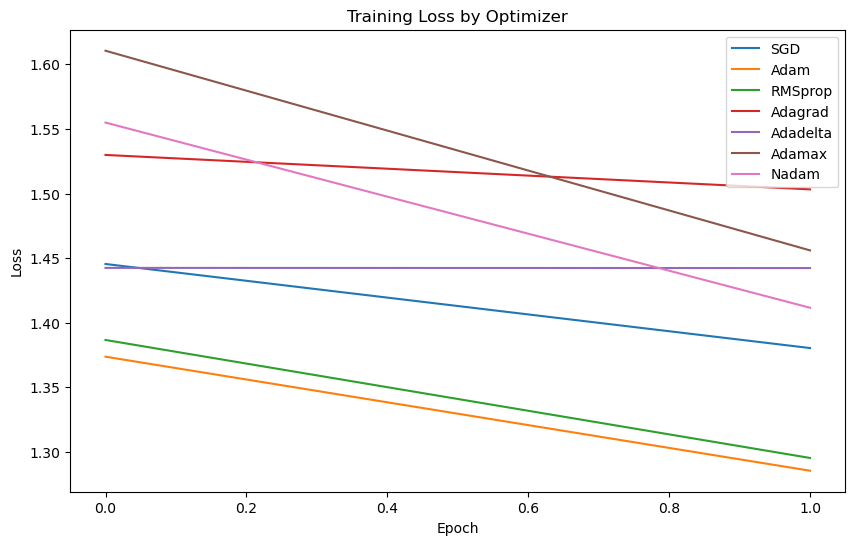

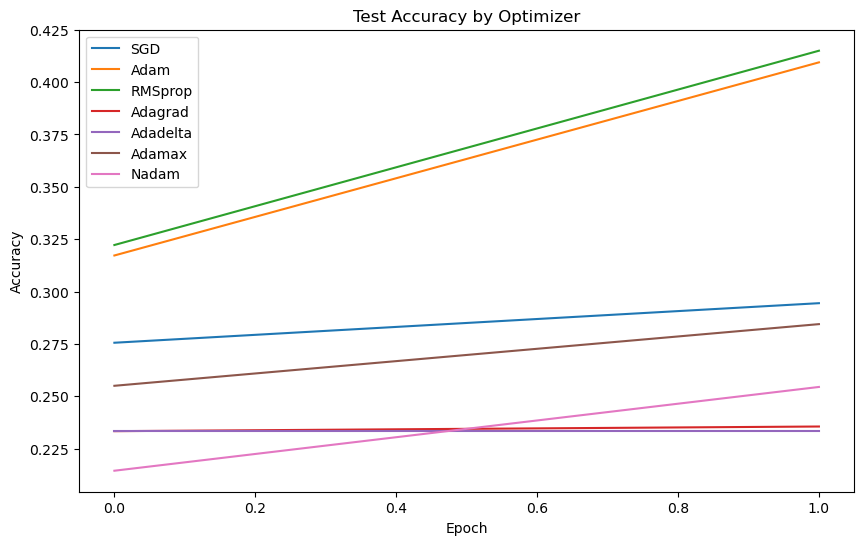

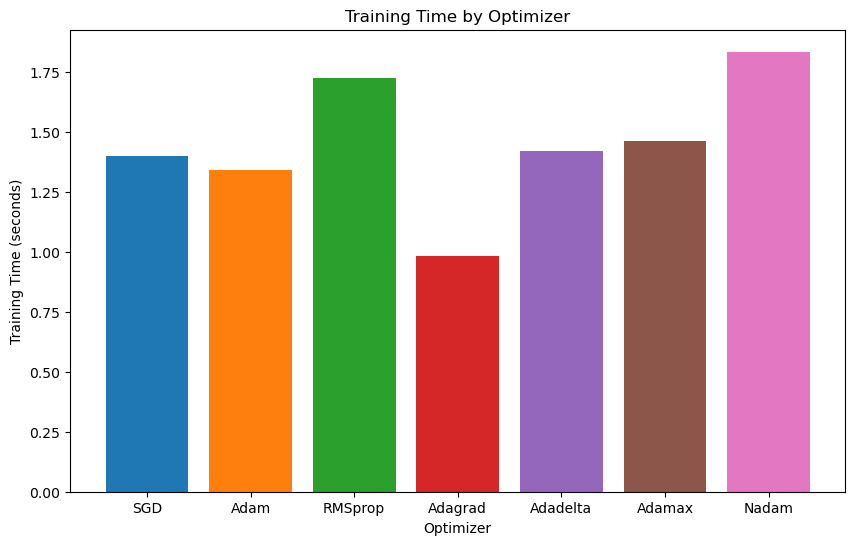

In [34]:
optimizers = {
    'SGD': 'SGD',
    'Adam': 'adam',
    'RMSprop': 'RMSprop',
    'Adagrad': 'Adagrad',
    'Adadelta': 'Adadelta',
    'Adamax': 'Adamax',
    'Nadam': 'Nadam'
}

results = {}

for name, optimizer_name in optimizers.items():
    print(f"Training model with {name} optimizer...")
    model_instance = NeuralNetworkModel()
    model_instance.build_ann(X_train.shape[1], optimizer=optimizer_name)
    start_time = time.time()
    history = model_instance.train(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))
    end_time = time.time()
    test_loss, test_acc = model_instance.evaluate(X_test, y_test)
    training_time = end_time - start_time
    results[name] = {'test_accuracy': test_acc, 'convergence_speed': len(history.history['loss']), 'training_time': training_time, 'history': history}


# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")

# Plot training history
plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['loss'], label=name)
plt.title('Training Loss by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['accuracy'], label=name)
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.bar(name, result['training_time'])
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')
plt.show()

In [35]:
# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Analyze metrics
best_optimizer = None
best_accuracy = 0
lowest_loss = float('inf')
shortest_training_time = float('inf')

for optimizer, metrics in optimizer_metrics.items():
    accuracy = metrics['accuracy']
    loss = metrics['loss']
    training_time = metrics['training_time']
    
    # Determine the best optimizer based on accuracy, loss, and training time
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss < lowest_loss:
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss == lowest_loss and training_time < shortest_training_time:
        shortest_training_time = training_time
        best_optimizer = optimizer

# Step 3: Print or return the best performing optimizer
print(f"Best performing optimizer: {best_optimizer}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Loss: {lowest_loss:.4f}")
print(f"Shortest Training Time: {shortest_training_time:.2f} seconds")

Best performing optimizer: Adam
Accuracy: 0.4250
Loss: 1.2855
Shortest Training Time: 1.34 seconds


Comparison of Optimizers:
          accuracy      loss  training_time
SGD          0.280  1.380446       1.401377
Adam         0.425  1.285507       1.343085
RMSprop      0.410  1.295383       1.726539
Adagrad      0.275  1.503244       0.983685
Adadelta     0.225  1.442353       1.419845
Adamax       0.305  1.456020       1.463999
Nadam        0.290  1.411627       1.835687


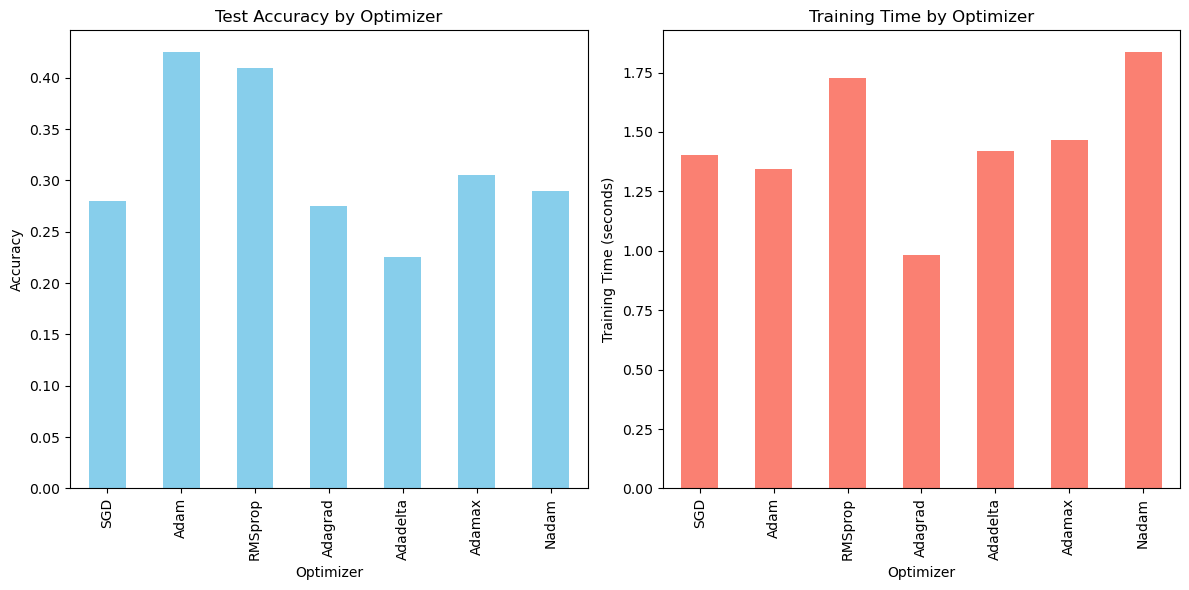

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Create a dataframe for comparison
df = pd.DataFrame(optimizer_metrics).T  # Transpose to have optimizers as rows

# Step 3: Plot the comparison using a table
print("Comparison of Optimizers:")
print(df)

# Step 4: Plot the comparison using a graph
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['accuracy'].plot(kind='bar', color='skyblue')
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
df['training_time'].plot(kind='bar', color='salmon')
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')

plt.tight_layout()
plt.show()


In [11]:
pip install tensorflow-addons

Note: you may need to restart the kernel to use updated packages.


In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score
import time
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam
import tensorflow as tf
# from keras.optimizers.schedules import ExponentialDecay
# from keras_contrib.optimizers import Yogi, Lookahead
import tensorflow_addons as tfa  # For AdamW, Yogi, and Lookahead

class DataPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.encoder = OneHotEncoder()
    
    def load_data(self, file_path):
        dataset = pd.read_csv(file_path)
        X = dataset.iloc[:,:20]
        y = dataset.iloc[:,20:21]
        return X, y

    def split_data(self, X, y, test_size=0.1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        return X_train, X_test, y_train, y_test

    def normalize_features(self, X):
        return self.scaler.fit_transform(X)

    def encode_targets(self, y):
        return self.encoder.fit_transform(y).toarray()

In [18]:
class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_ann(self, input_dim, optimizer='adam'):
        # Initialize and compile the model within the build_ann method
        model = Sequential()
        model.add(Dense(16, input_dim=input_dim, activation='relu'))
        model.add(Dense(12, activation='relu'))
        model.add(Dense(4, activation='softmax'))
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        self.model = model

    def train(self, X_train, y_train, epochs=100, batch_size=32, validation_data=None):
        # Train the model with the provided parameters
        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)
        return history
    
    def evaluate(self, X_test, y_test):
        # Evaluate the model and return the results
        return self.model.evaluate(X_test, y_test)

In [19]:
# Main process
data_preprocessor = DataPreprocessor()
X, y = data_preprocessor.load_data('mobile-train (1).csv')
X = data_preprocessor.normalize_features(X)
y = data_preprocessor.encode_targets(y)
X_train, X_test, y_train, y_test = data_preprocessor.split_data(X, y)

Training model with SGD optimizer...
Epoch 1/100
57/57 [==============================] - 1s 11ms/step - loss: 1.5520 - accuracy: 0.2550 - val_loss: 1.5146 - val_accuracy: 0.2600
Epoch 2/100
57/57 [==============================] - 0s 7ms/step - loss: 1.4250 - accuracy: 0.2844 - val_loss: 1.4264 - val_accuracy: 0.2750
Epoch 3/100
57/57 [==============================] - 0s 8ms/step - loss: 1.3593 - accuracy: 0.3206 - val_loss: 1.3655 - val_accuracy: 0.3200
Epoch 4/100
57/57 [==============================] - 0s 7ms/step - loss: 1.3068 - accuracy: 0.3472 - val_loss: 1.3108 - val_accuracy: 0.3450
Epoch 5/100
57/57 [==============================] - 0s 7ms/step - loss: 1.2563 - accuracy: 0.3722 - val_loss: 1.2546 - val_accuracy: 0.3900
Epoch 6/100
57/57 [==============================] - 0s 7ms/step - loss: 1.2028 - accuracy: 0.4083 - val_loss: 1.1962 - val_accuracy: 0.4250
Epoch 7/100
57/57 [==============================] - 0s 8ms/step - loss: 1.1447 - accuracy: 0.4411 - val_loss: 1.135

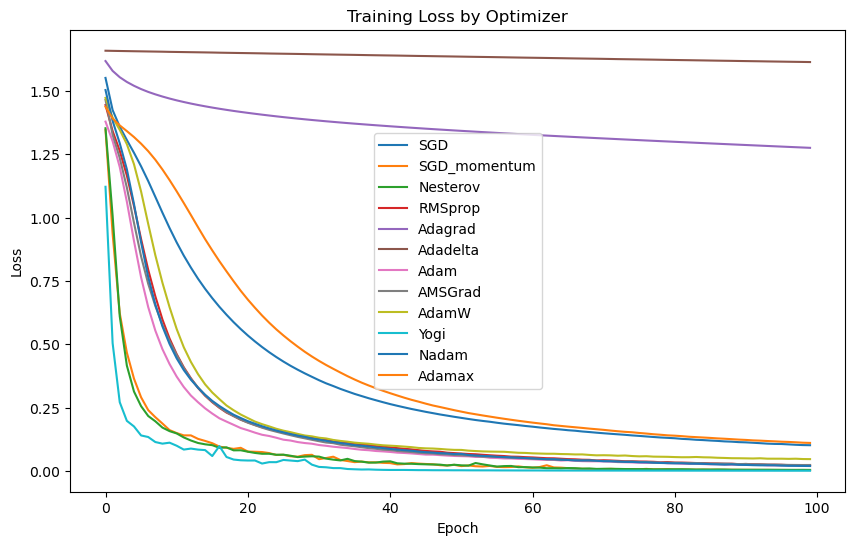

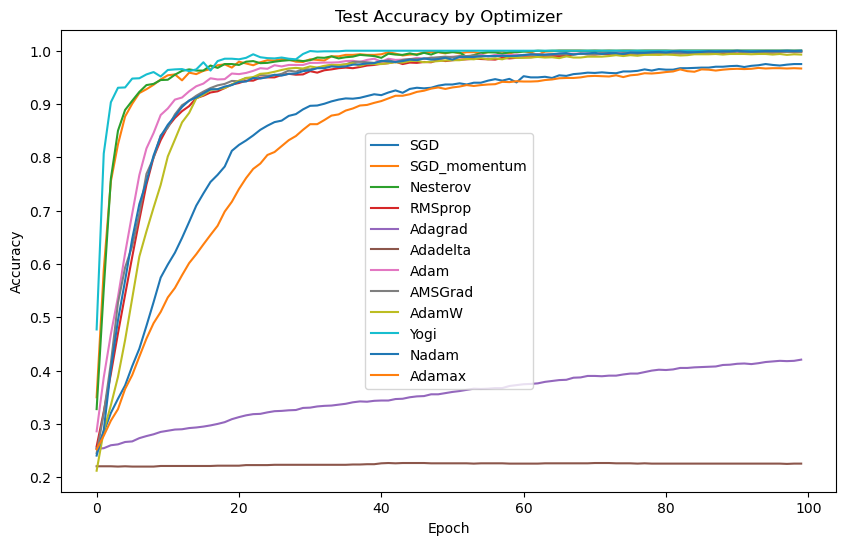

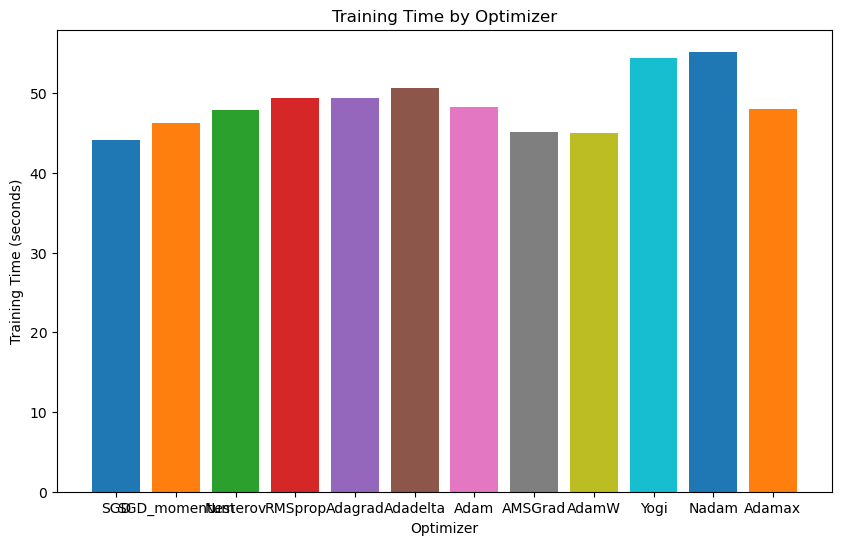

In [23]:
import time
import matplotlib.pyplot as plt

# List of optimizers to test for NN
optimizers = {
    'SGD': tf.keras.optimizers.SGD(),
    'SGD_momentum': tf.keras.optimizers.SGD(momentum=0.9),
    'Nesterov': tf.keras.optimizers.SGD(momentum=0.9, nesterov=True),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adam': tf.keras.optimizers.Adam(),
    'AMSGrad': tf.keras.optimizers.Adam(amsgrad=True),
    'AdamW': tfa.optimizers.AdamW(weight_decay=1e-4),
    'Yogi': tfa.optimizers.Yogi(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Adamax': tf.keras.optimizers.Adamax()
}

results = {}


for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    model_instance = NeuralNetworkModel()
    model_instance.build_ann(X_train.shape[1], optimizer=optimizer)
    start_time = time.time()
    history = model_instance.train(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
    end_time = time.time()
    test_loss, test_acc = model_instance.evaluate(X_test, y_test)
    training_time = end_time - start_time
    results[name] = {'test_accuracy': test_acc, 'convergence_speed': len(history.history['loss']), 'training_time': training_time, 'history': history}


# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")

# Plot training history
plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['loss'], label=name)
plt.title('Training Loss by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result['history'].history['accuracy'], label=name)
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.bar(name, result['training_time'])
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')
plt.show()

In [24]:
# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Analyze metrics
best_optimizer = None
best_accuracy = 0
lowest_loss = float('inf')
shortest_training_time = float('inf')

for optimizer, metrics in optimizer_metrics.items():
    accuracy = metrics['accuracy']
    loss = metrics['loss']
    training_time = metrics['training_time']
    
    # Determine the best optimizer based on accuracy, loss, and training time
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss < lowest_loss:
        lowest_loss = loss
        shortest_training_time = training_time
        best_optimizer = optimizer
    elif accuracy == best_accuracy and loss == lowest_loss and training_time < shortest_training_time:
        shortest_training_time = training_time
        best_optimizer = optimizer

# Step 3: Print or return the best performing optimizer
print(f"Best performing optimizer: {best_optimizer}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Loss: {lowest_loss:.4f}")
print(f"Shortest Training Time: {shortest_training_time:.2f} seconds")

Best performing optimizer: Nesterov
Accuracy: 0.9400
Loss: 0.0039
Shortest Training Time: 47.86 seconds


Comparison of Optimizers:
              accuracy      loss  training_time
SGD              0.900  0.101490      44.078432
SGD_momentum     0.915  0.003262      46.290765
Nesterov         0.940  0.003909      47.861466
RMSprop          0.890  0.021636      49.381041
Adagrad          0.370  1.275872      49.363312
Adadelta         0.235  1.614590      50.597491
Adam             0.905  0.019491      48.237494
AMSGrad          0.905  0.023352      45.103356
AdamW            0.930  0.046511      44.978927
Yogi             0.900  0.000710      54.381291
Nadam            0.910  0.019333      55.191681
Adamax           0.905  0.110539      48.006220


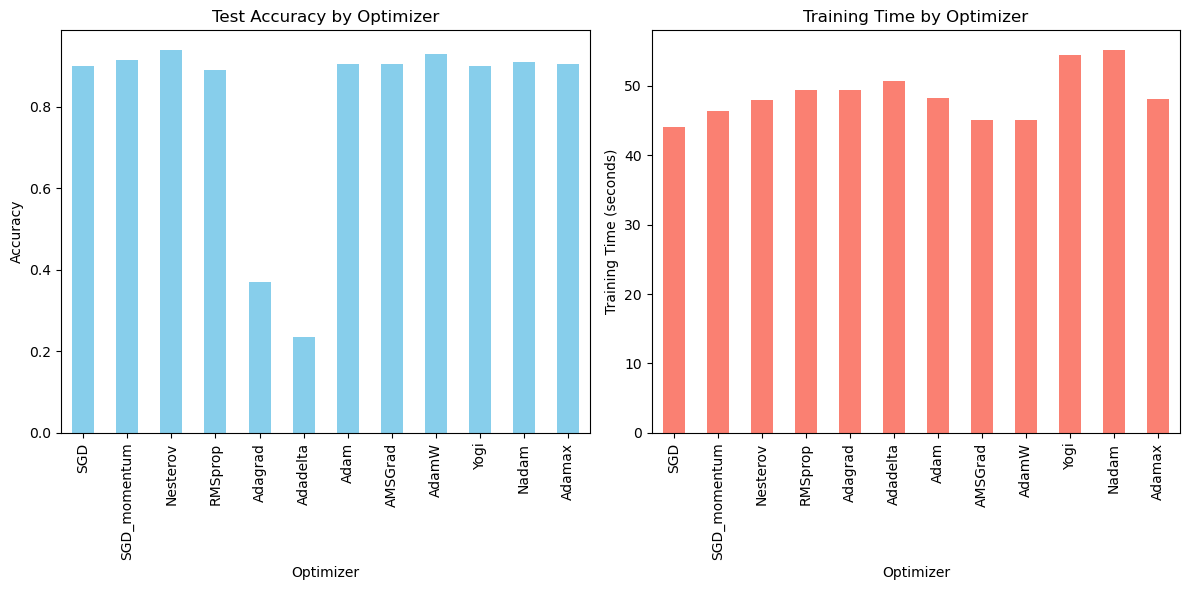

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Collect results and metrics
optimizer_metrics = {}  # Dictionary to store optimizer metrics

for optimizer, result in results.items():
    accuracy = result['test_accuracy']
    loss = result['history'].history['loss'][-1]
    training_time = result['training_time']
    optimizer_metrics[optimizer] = {'accuracy': accuracy, 'loss': loss, 'training_time': training_time}

# Step 2: Create a dataframe for comparison
df = pd.DataFrame(optimizer_metrics).T  # Transpose to have optimizers as rows

# Step 3: Plot the comparison using a table
print("Comparison of Optimizers:")
print(df)

# Step 4: Plot the comparison using a graph
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
df['accuracy'].plot(kind='bar', color='skyblue')
plt.title('Test Accuracy by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
df['training_time'].plot(kind='bar', color='salmon')
plt.title('Training Time by Optimizer')
plt.xlabel('Optimizer')
plt.ylabel('Training Time (seconds)')

plt.tight_layout()
plt.show()
